# Kaggle 2019 ML month 2nd baseline 연습
목표는 집값 예측하기
## 데이터 셋 다운로드

In [91]:
import kaggle
import zipfile

kaggle.api.competition_download_cli("2019-2nd-ml-month-with-kakr")
with zipfile.ZipFile("2019-2nd-ml-month-with-kakr.zip", "r") as zipref:
    zipref.extractall("./")

2019-2nd-ml-month-with-kakr.zip: Skipping, found more recently modified local copy (use --force to force download)


In [124]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [166]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

display(train)
print(test.loc[6467, :])

train data dim : (15035, 21)
test data dim : (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


id                         21502
date             20150116T000000
bedrooms                       3
bathrooms                    2.5
sqft_living                 1600
sqft_lot                    2388
floors                       2.0
waterfront                     0
view                           0
condition                      3
grade                          8
sqft_above                  1600
sqft_basement                  0
yr_built                    2004
yr_renovated                   0
zipcode                    98027
lat                      47.5345
long                    -122.069
sqft_living15               1410
sqft_lot15                  1287
Name: 6467, dtype: object


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

# 분석
## 결측치 찾기
### missingno로 결측치를 매트릭스로 표현하기

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


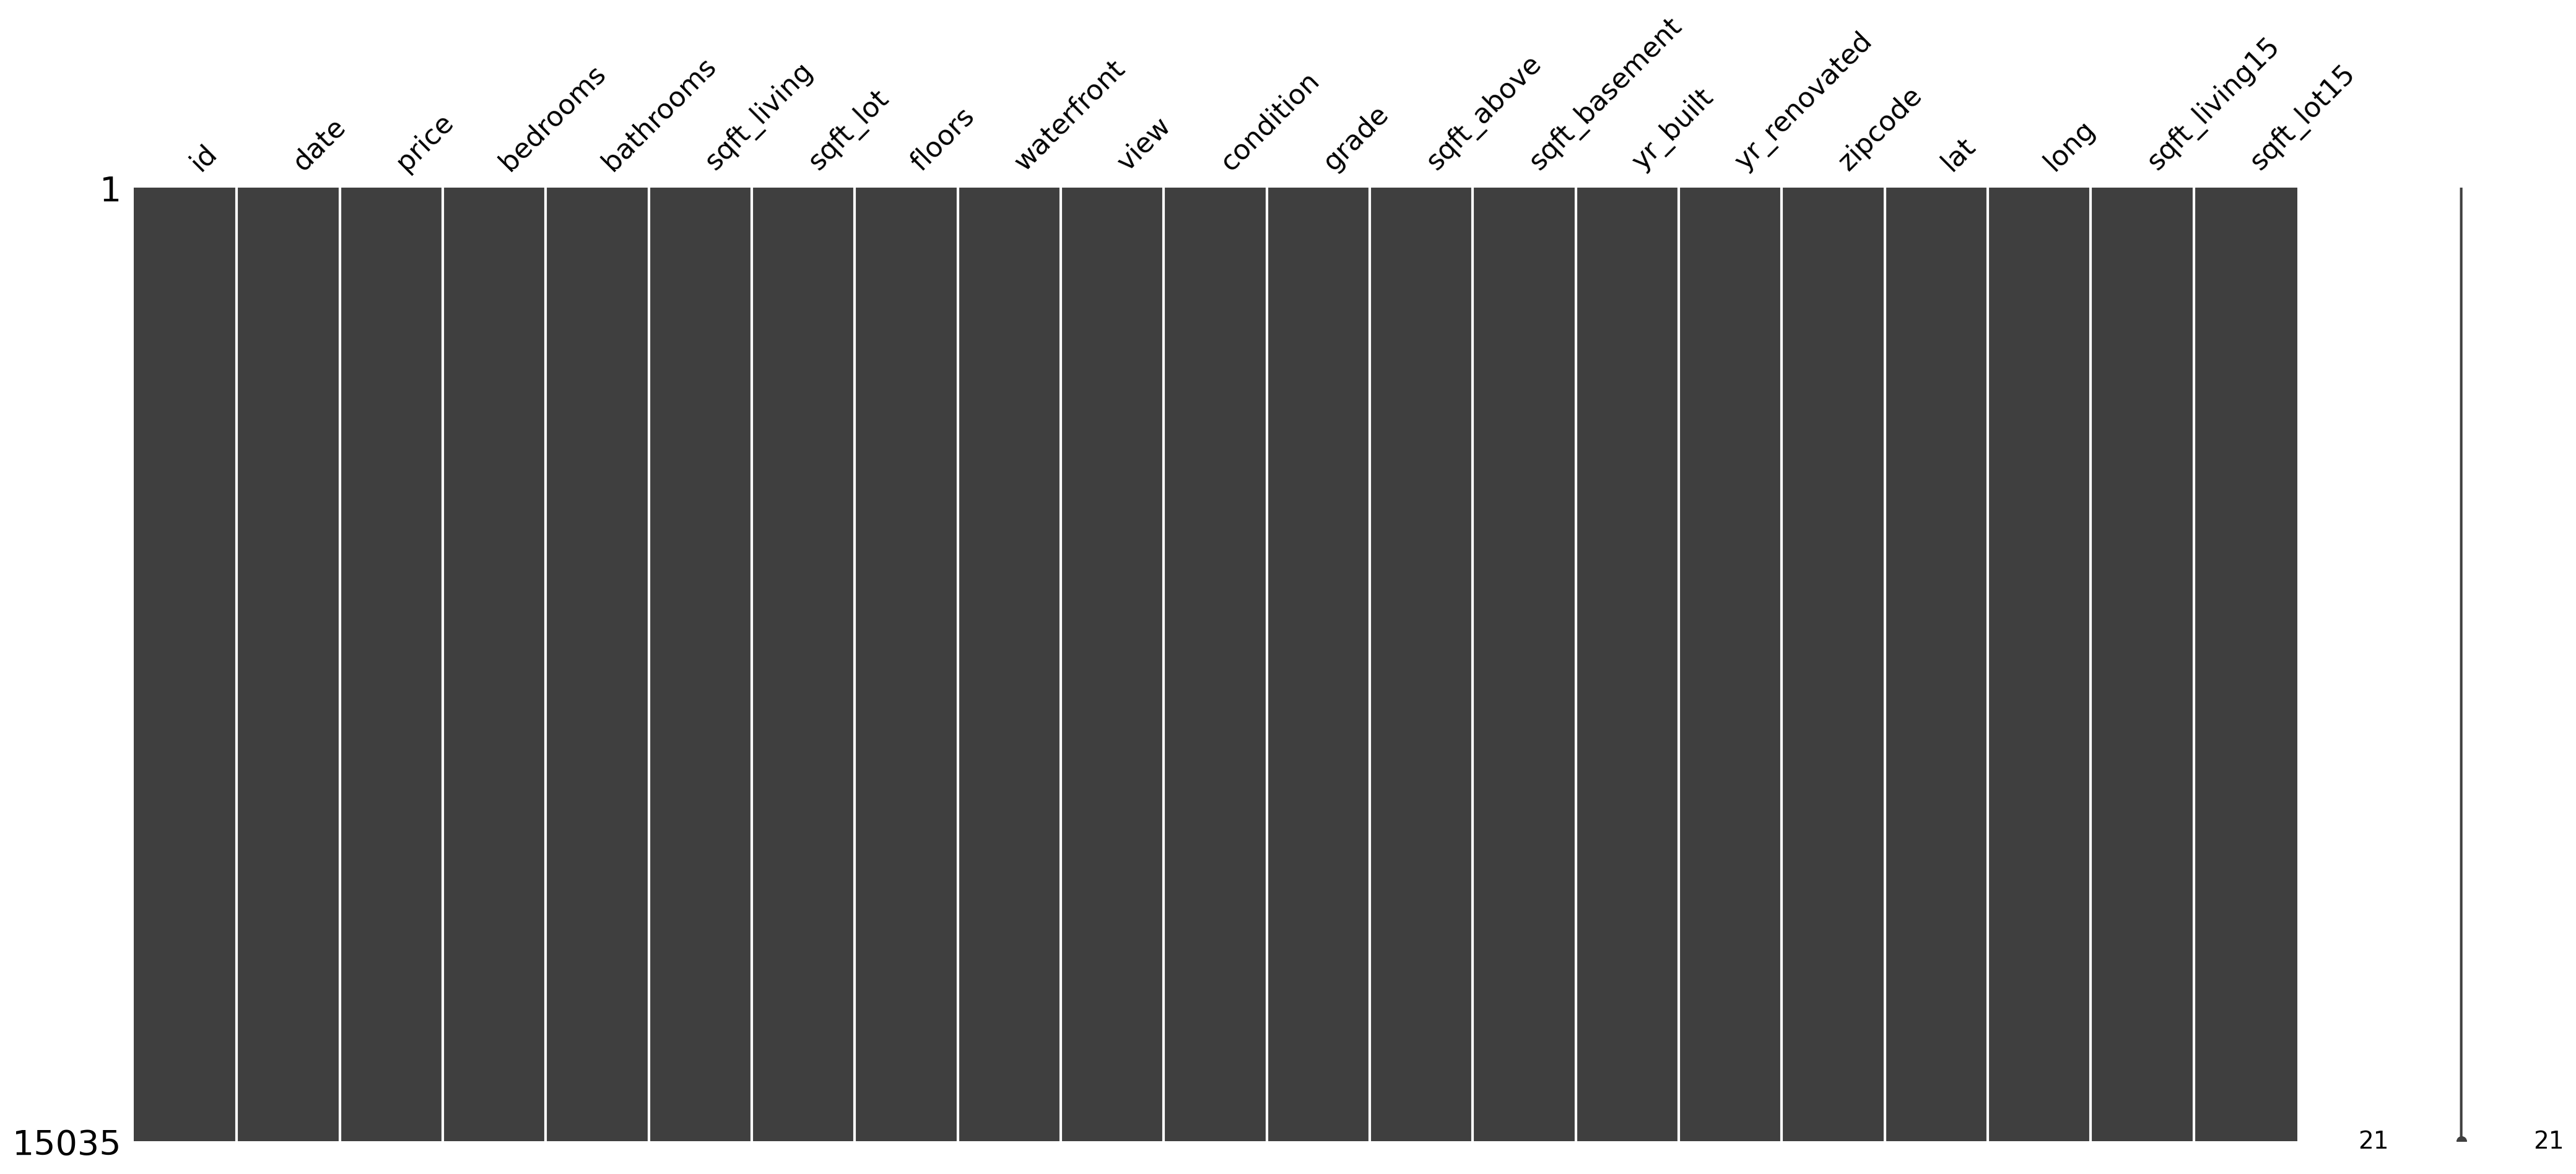

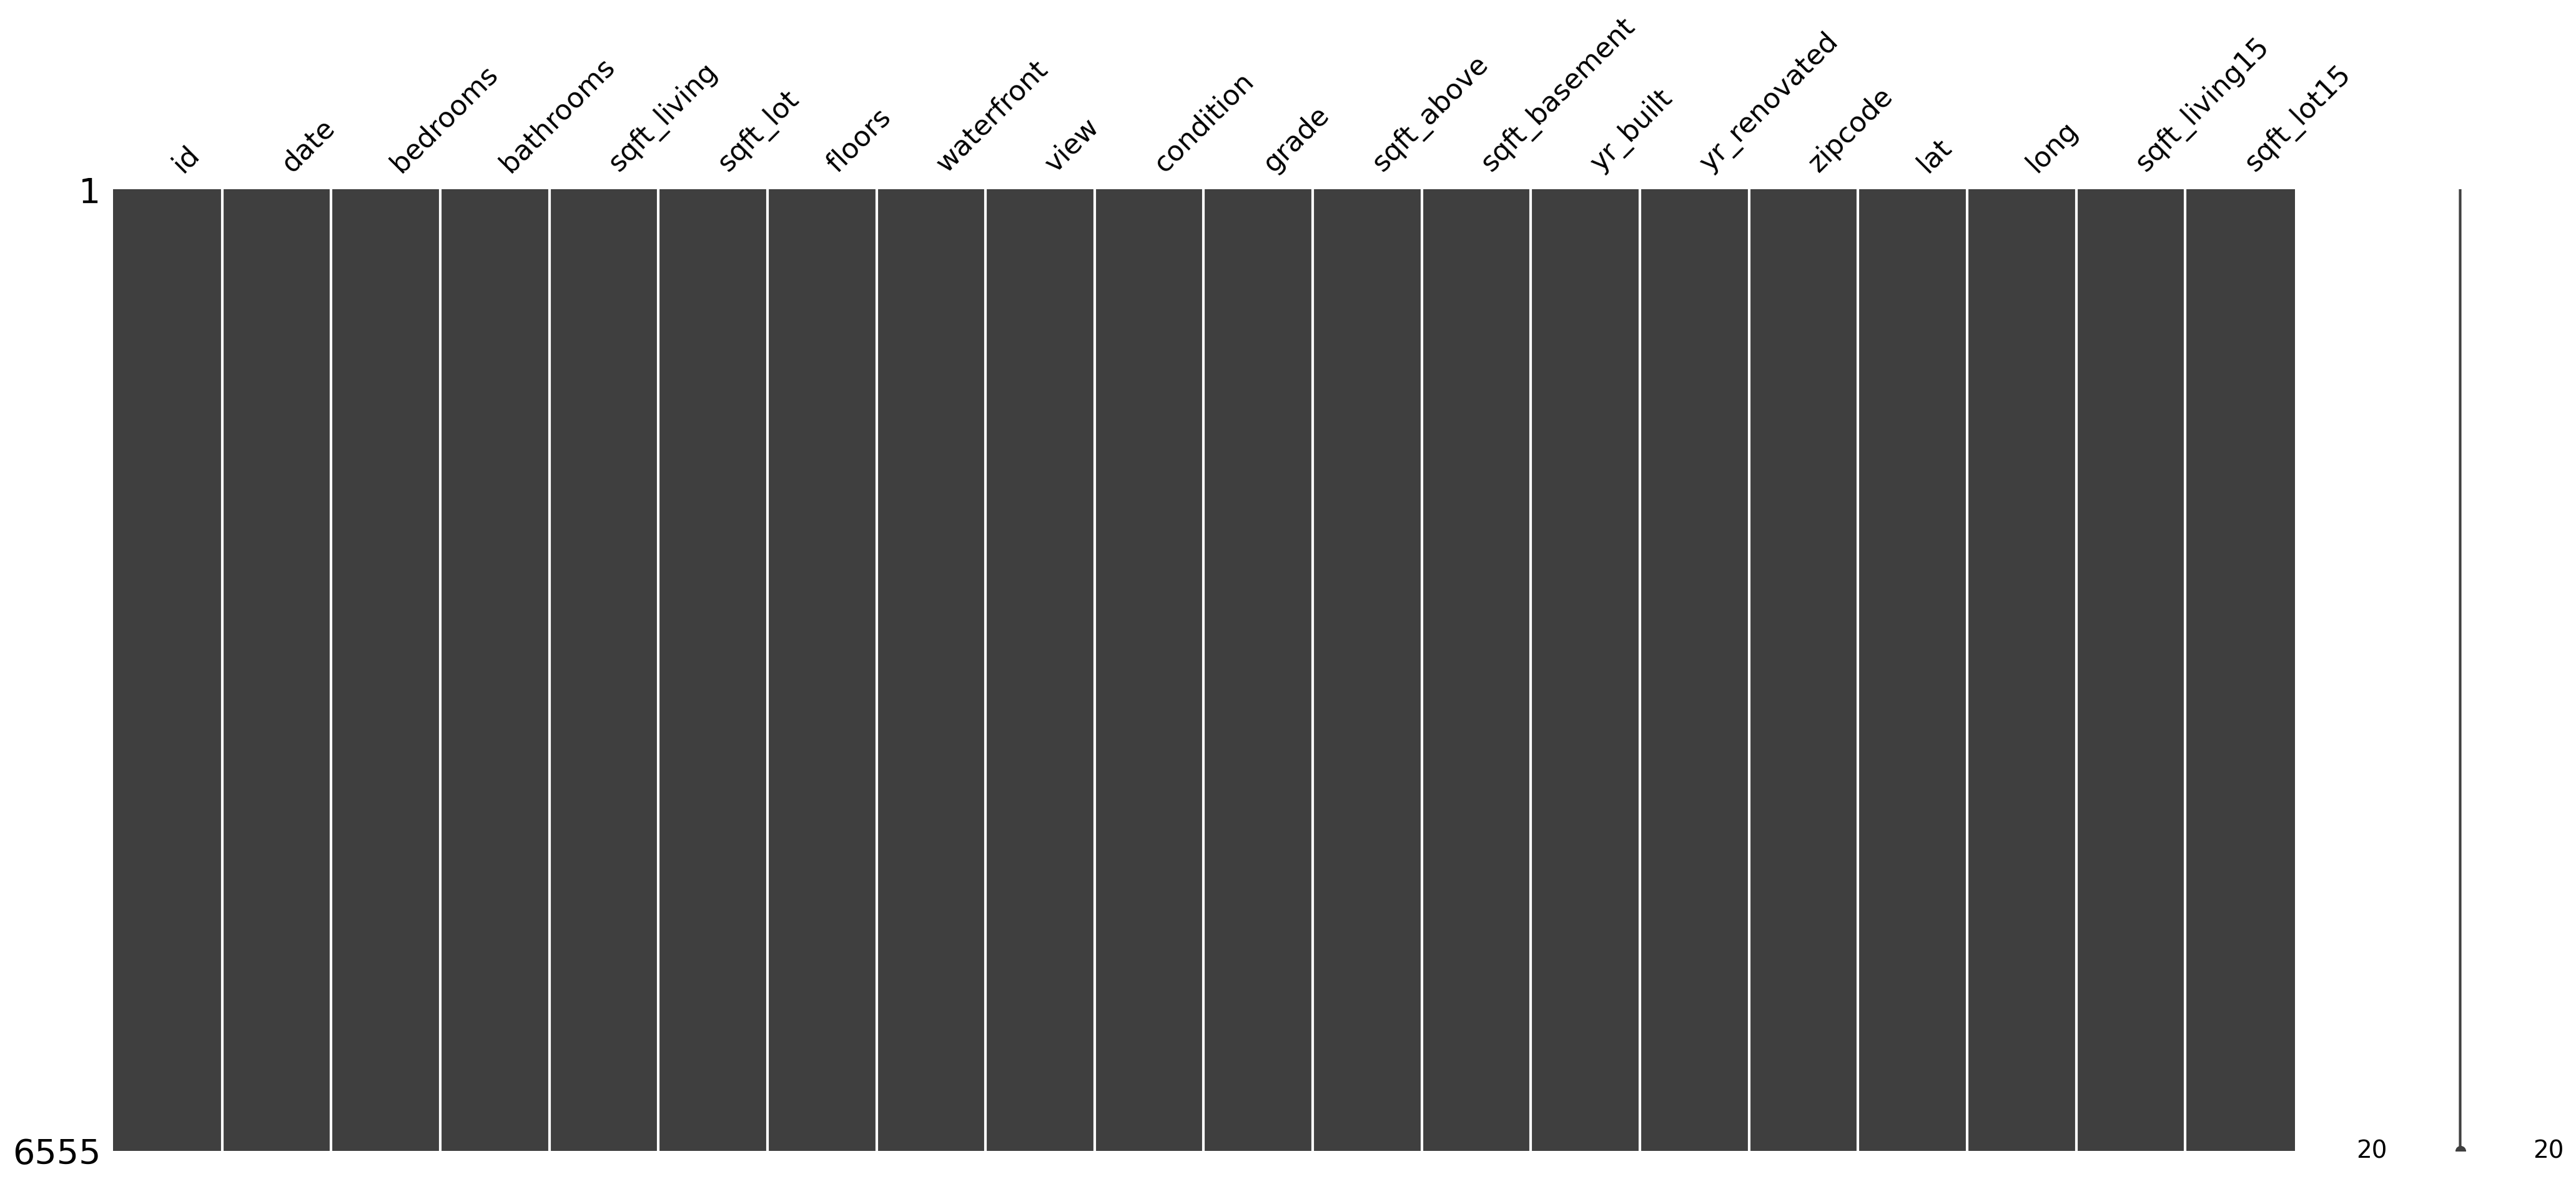

In [7]:
msno.matrix(train)
print(train.isnull().sum())

msno.matrix(test)
print(test.isnull().sum())

## 불필요한 ID 컬럼 삭제

In [126]:
train.drop("id", inplace=True, axis=1)
test_id = test['id']
test.drop("id", inplace=True, axis=1)
display(test_id)

0       15208
1       15209
2       15210
3       15211
4       15212
        ...  
6550    21758
6551    21759
6552    21760
6553    21761
6554    21762
Name: id, Length: 6555, dtype: int64

## 연월일시 데이터 가공
20141013T000000 형식에서 연도 4자리와 월에 해당하는 2자리만 사용

In [127]:
train['date'] = train['date'].apply(lambda x : str(x[:6]))
test['date'] = test['date'].apply(lambda x : str(x[:6]))

print(train.shape, test.shape)

(15035, 20) (6555, 19)


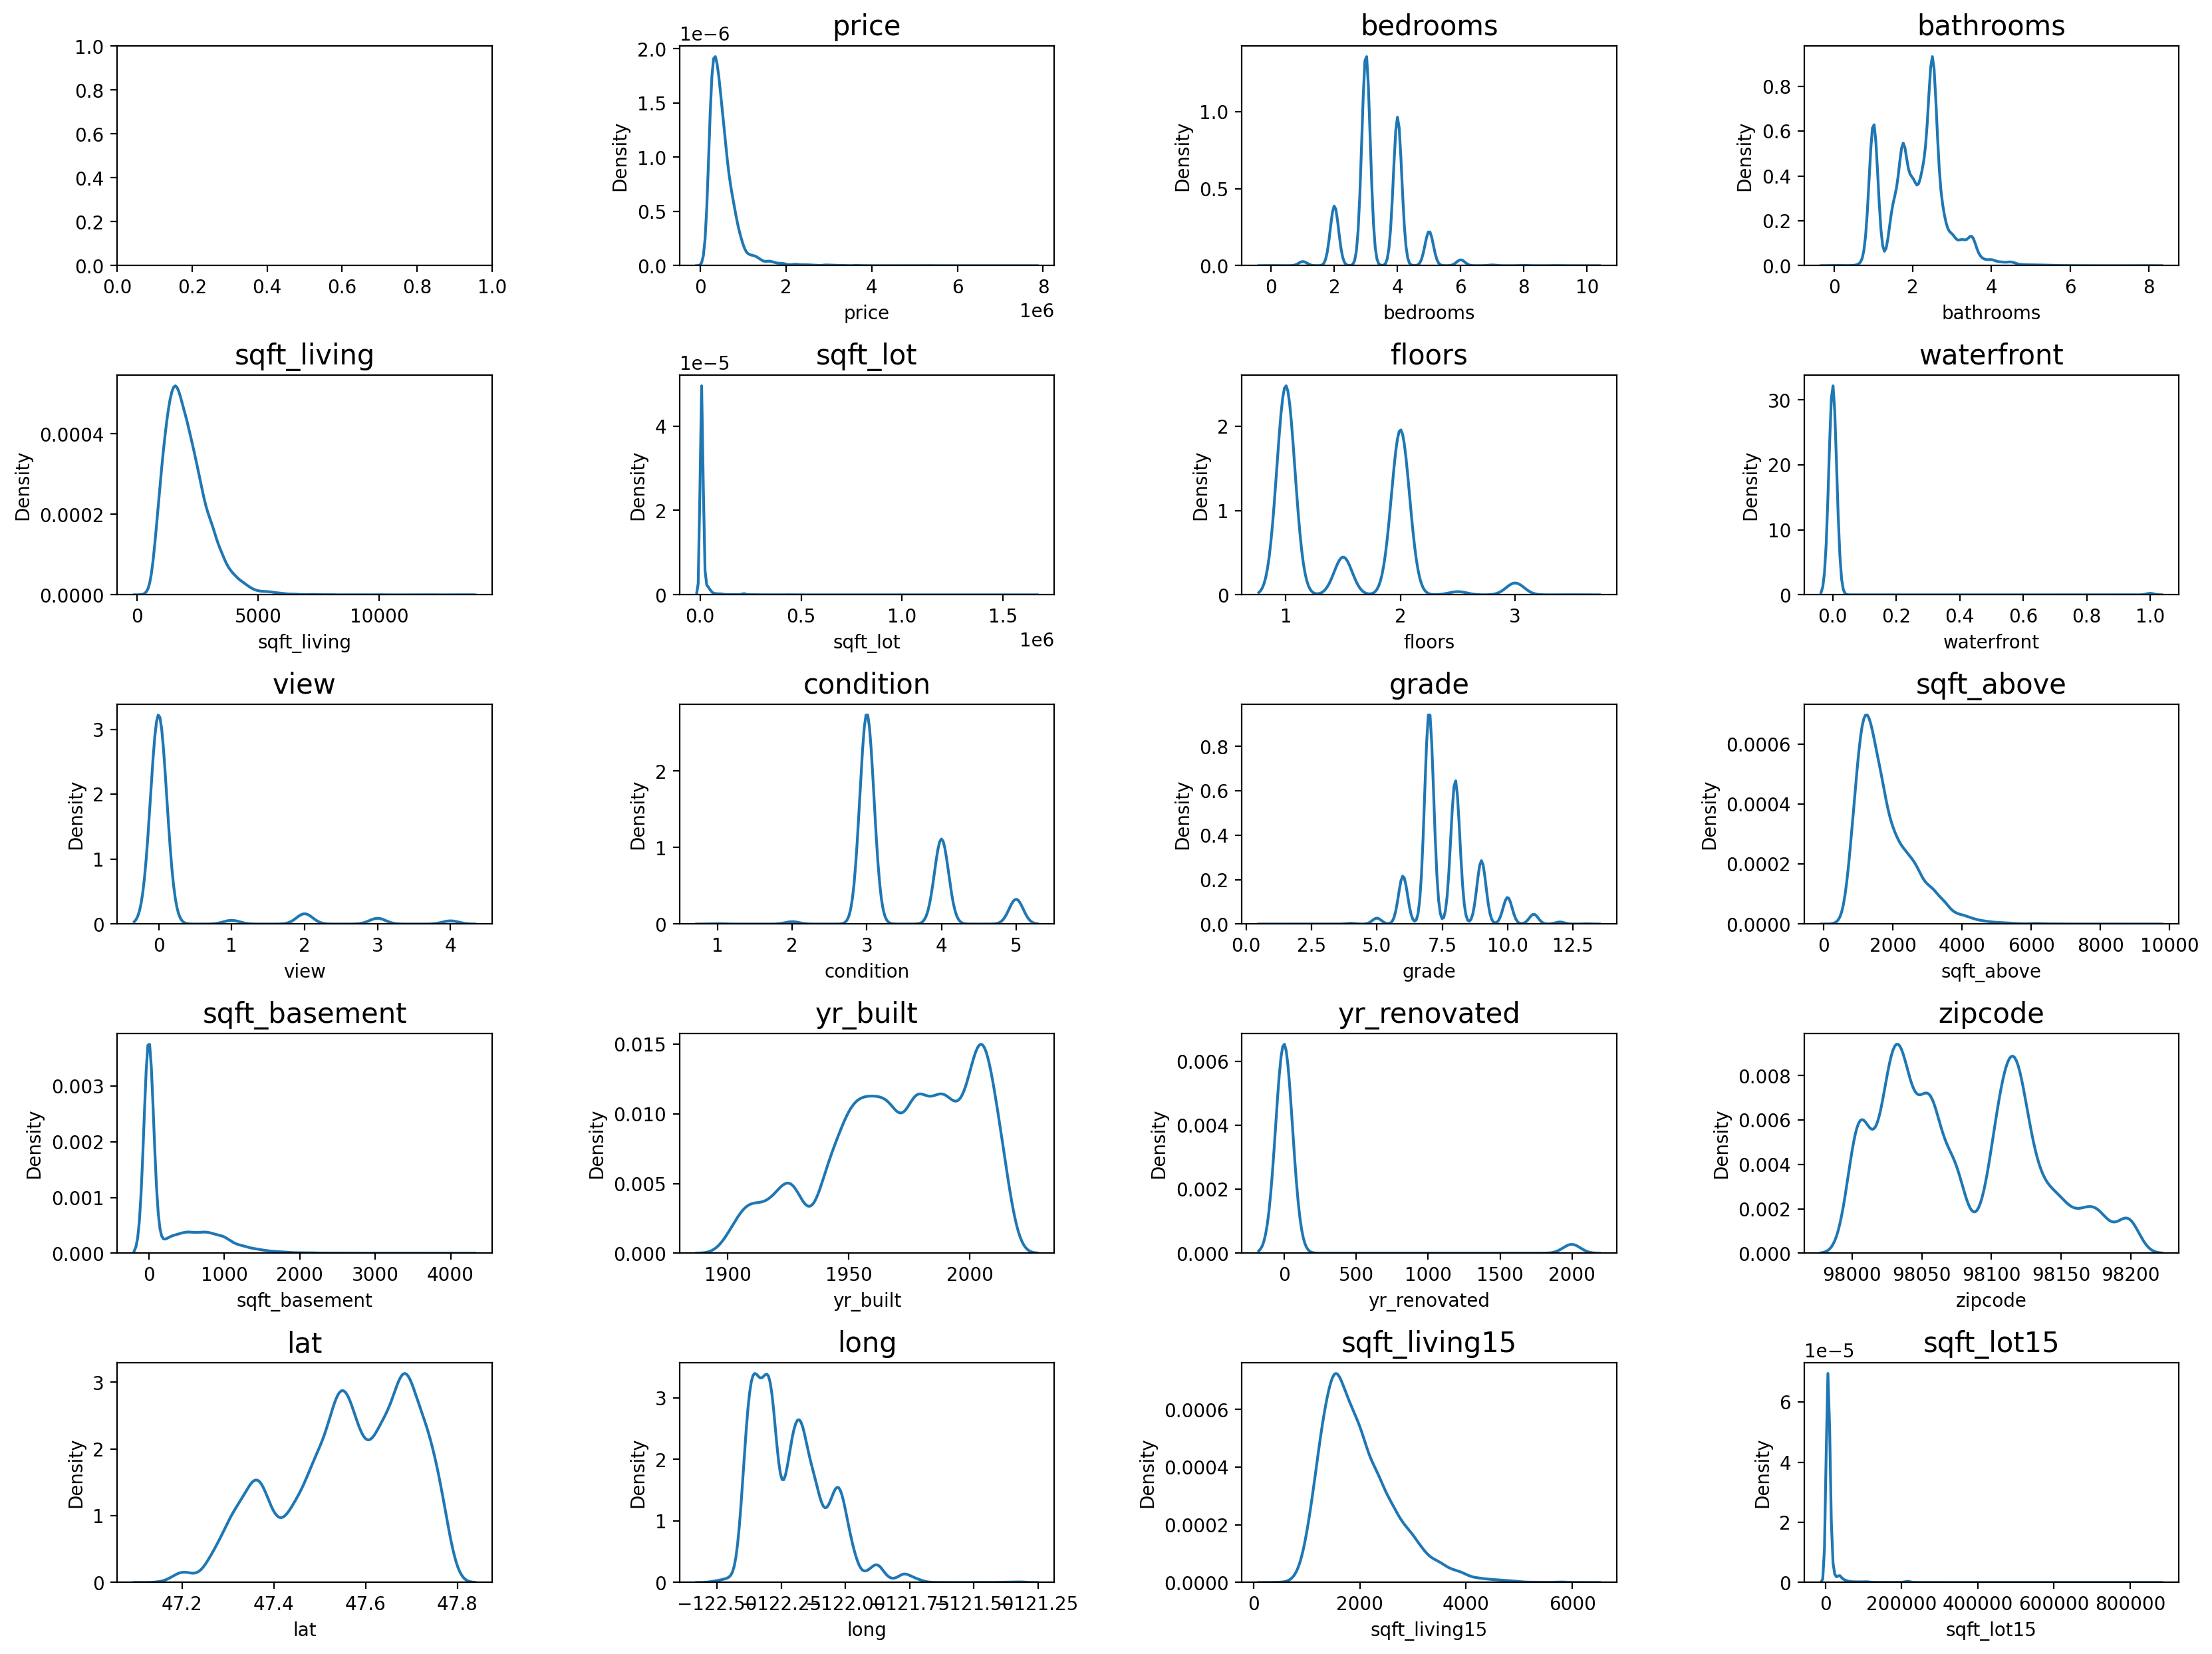

In [112]:
rows, cols = 5, 4
fig, ax = plt.subplots(rows, cols, figsize=(20, 15))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 맨 앞에 위치한 date 컬럼을 제외하기 위해 0번 인덱스 제외하고 1번부터 loop
for i in range(1, len(train.columns)):
    row, col = divmod(i, cols)
    sns.kdeplot(data=train[train.columns[i]], ax=ax[row][col])
    ax[row][col].set_title(train.columns[i], fontsize=15)        

## 로그변환을 통해 치우친 분포를 정규분포로 비슷하게 만들어주기
로그함수는 0에 가까운 값들은 y값이 가파르게 벌어지게 되고 충분히 큰 x값은 y값의 작은 구간에 모아두게 된다.  
그래서 한쪽으로 몰려있는 데이터들에 작은 값은 멀리 퍼뜨리고 큰 값은 모이게 하는 특성이 있다.

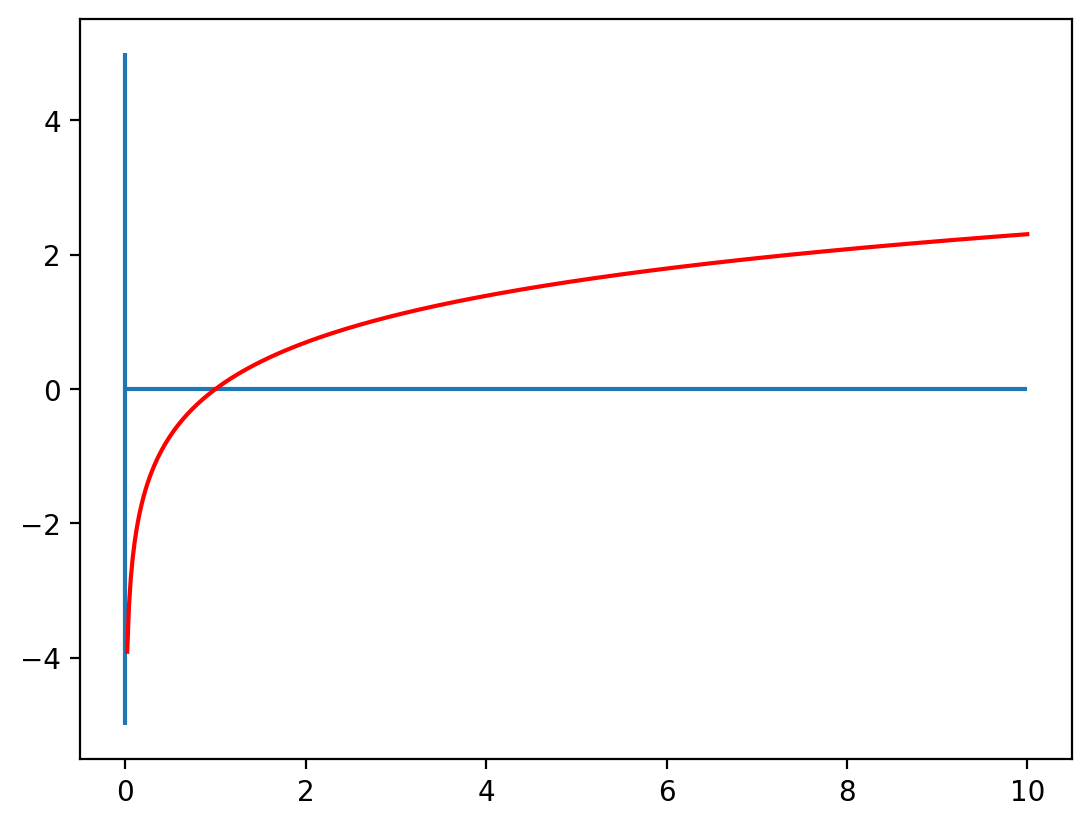

In [99]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

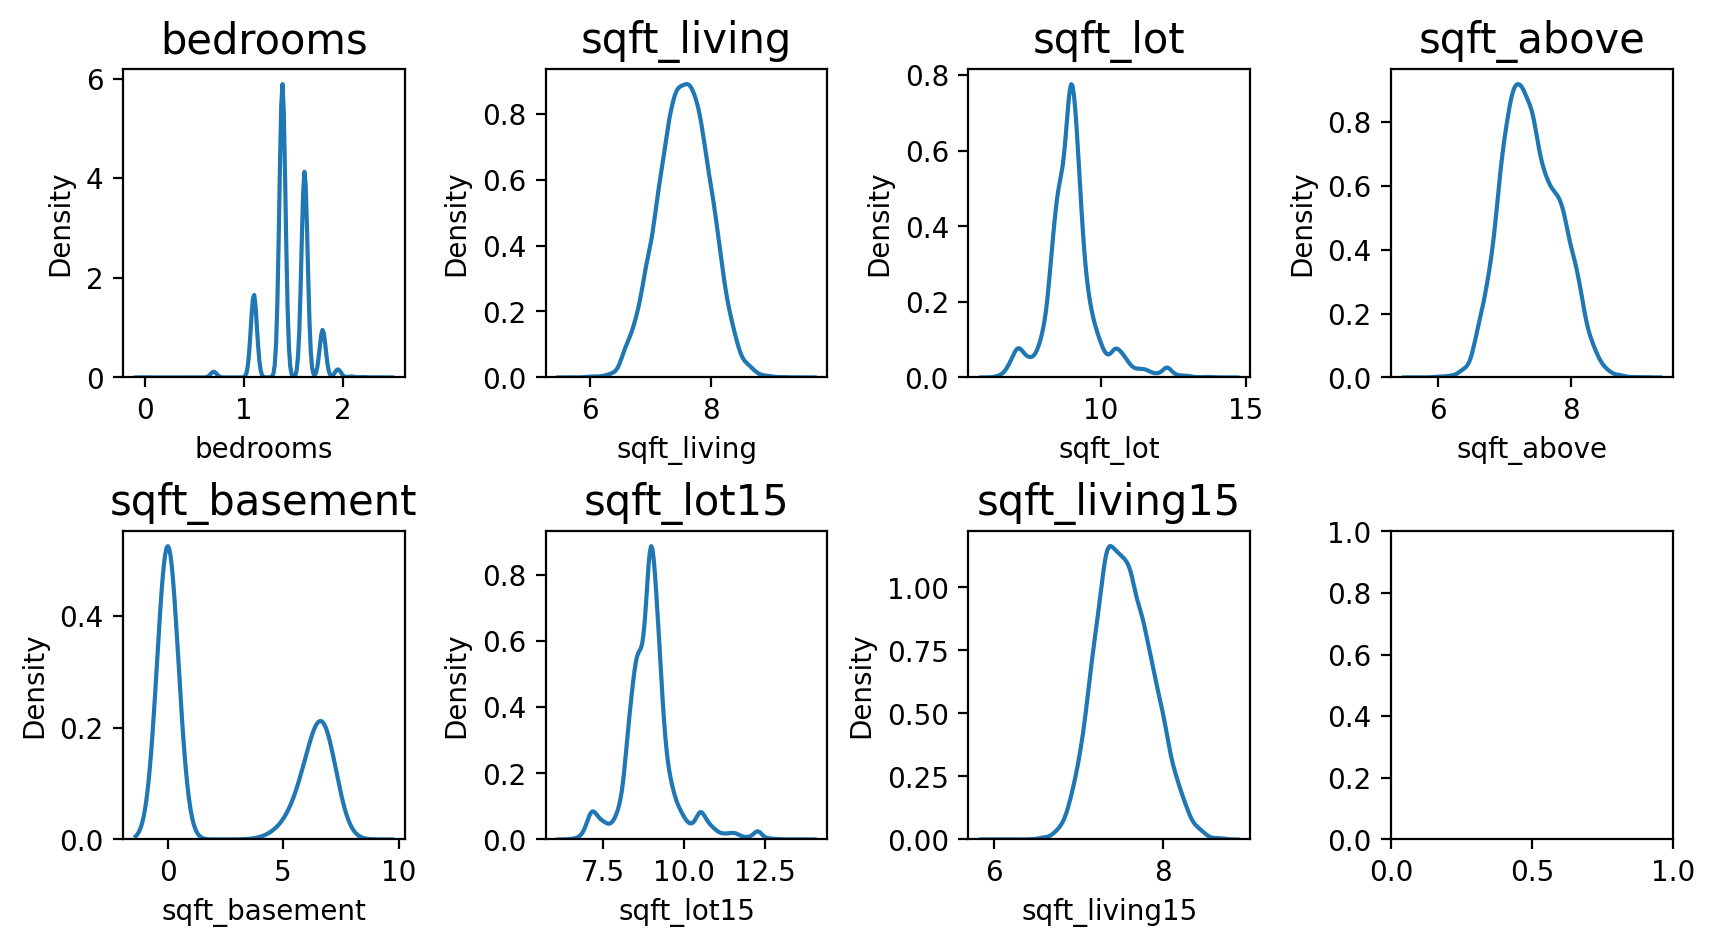

In [128]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for columns in skew_columns:
    train[columns] = np.log1p(train[columns].values)

rows, cols = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(10, 5))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 맨 앞에 위치한 date 컬럼을 제외하기 위해 0번 인덱스 제외하고 1번부터 loop
for i in range(0, len(skew_columns)):
    row, col = divmod(i, cols)
    sns.kdeplot(data=train[skew_columns[i]], ax=ax[row][col])
    ax[row][col].set_title(skew_columns[i], fontsize=15)        

# [앙상블 모델 만들기](https://jamm-notnull.tistory.com/16)

In [139]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

def get_cv_score(x, y, models):
    kfold = KFold(n_splits=5).get_n_splits(x)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")


x = train.loc[:, train.columns!="price"].values
y = train['price'].values
get_cv_score(x, y, models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [116]:
def AveragingBlending(models, x, y, sub_x:pd.DataFrame):
    for m in models : 
        m['model'].fit(x, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, test)
print(len(y_pred))

result = pd.DataFrame({
    'id' : test_id, 
    'price' : y_pred
})

result.head()

6555


,id,price
0,15208,2.541247e+06
1,15209,1.251769e+06
2,15210,3.191076e+06
3,15211,1.836098e+06
4,15212,1.927330e+06


## 캐글 제출

In [117]:
result.to_csv("./submission.csv", index=False)
kaggle.api.competition_submit_cli(file_name="submission.csv", competition="2019-2nd-ml-month-with-kakr", message="Message")

100%|██████████| 158k/158k [00:03<00:00, 47.9kB/s] 


Successfully submitted to 2019 2nd ML month with KaKR

# 모델 튜닝

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def rmse(y_test, y_pred):
    # log1p를 역변환 함
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

df = {}

y = np.log1p(y)
# train, test 데이터셋 분리
# random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    print(model_name)

    # 모델 학습
    model.fit(x_train, y_train)

    score = model.score(x_test, y_test)
    print(score)
        
    # 예측
    y_pred = model.predict(x_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

GradientBoostingRegressor
0.8787759433182003
XGBRegressor
0.8965765863477259
LGBMRegressor
0.9008359096869598
RandomForestRegressor
0.8837307998941146


# 파라미터 튜닝
하이퍼 파라미터를 조합해 보는 방법
## 그리드 탐색
* 그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색. 
* 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 사용 
* 그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 가능성이 있음

## 랜덤 탐색
* 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법.
* 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성 있음

## Scikit-Learn의  `GridSearchCV`
* `param_grid` : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* `scoring` : 모델의 성능을 평가할 지표
* `cv` : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* `verbose` : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* `n_jobs` : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

# param_grid에 n_estimators 두 가지, max_depth 두 가지 x cross validation 데이터세트 5개이므로 나올 수 있는 
# 파라미터 조합 4 x 5 묶음
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=16)

grid_model.fit(x, y)
print(grid_model.cv_results_)
print(grid_model.cv_results_['params'])
print(grid_model.cv_results_['mean_test_score'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'mean_fit_time': array([0.09103436, 0.12524161, 0.24322371, 0.32590852]), 'std_fit_time': array([0.00836473, 0.00307858, 0.00802404, 0.02400492]), 'mean_score_time': array([0.01031733, 0.01232328, 0.01878552, 0.02617869]), 'std_score_time': array([0.0022481 , 0.00165307, 0.00276418, 0.00235556]), 'param_max_depth': masked_array(data=[1, 1, 10, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}], 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]), 'split1_test_score': array([-0.00038423, -0.00029198, -0.00015652, -0.00014476]), 

,max_depth,n_estimators,score
0,1,50,-0.000368
1,1,100,-0.000277
2,10,50,-0.000151
3,10,100,-0.000140


**유의**
그리드 탐색에서 들어간 y가 위의 셀에서 logp1 변환을 거쳤기 때문에 neg mse로부터 구한 RMSE는 사실 로그를 취한 값에 대한 에러이므로  
RMSLE로 표기해준다.

In [164]:
results = pd.DataFrame(grid_model.cv_results_['params'])
results['neg_mse'] = grid_model.cv_results_['mean_test_score']
results['RMSE'] = np.sqrt(-1 * results['neg_mse'])
results = results.rename(columns={'RMSE': 'RMSLE'})
display(results.sort_values("RMSLE", axis=0))

,max_depth,n_estimators,neg_mse,RMSLE
3,10,100,-0.000140,0.011836
2,10,50,-0.000151,0.012278
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019175


# 그리드 탐색으로 제출하기

In [169]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

train.drop("id", inplace=True, axis=1)
test_id = test['id']
test.drop("id", inplace=True, axis=1)

train['date'] = train['date'].apply(lambda x : str(x[:6]))
test['date'] = test['date'].apply(lambda x : str(x[:6]))

x = train.loc[:, train.columns!="price"].values
y = train['price'].values
y = np.log1p(y)

## 최적의 파라미터 조합 찾기

In [170]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

def GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(x, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


model = LGBMRegressor(random_state=random_state)
display(GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_es

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [175]:
x_test = test.loc[:, test.columns!="price"].values

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(x, y)

y_pred = model.predict(x_test)
y_pred = np.expm1(y_pred)
print(model.score(x, y))

print(y_pred.shape)

0.931582978573174
(6468,)


In [176]:
result = pd.DataFrame({
    "id": test_id,
    "price": y_pred
})
result.to_csv("./submission.csv", index=False)
kaggle.api.competition_submit_cli(file_name="submission.csv", competition="2019-2nd-ml-month-with-kakr", message="Message")

100%|██████████| 153k/153k [00:02<00:00, 55.4kB/s] 


Successfully submitted to 2019 2nd ML month with KaKR